In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests 
from bs4 import BeautifulSoup


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Modelos de Regresión
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Metricas
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


# Métodos de validación
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# Tuning
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("coches.csv")
df

,Precio,Combustible,Año,Km,CV,Provincia,Marca
0,7999,Diésel,1993,293234,115.0,Zaragoza,NISSAN
1,10990,Gasolina,1993,187000,320.0,Valencia,MERCEDES-BENZ
2,5990,Gasolina,1993,80000,145.0,Madrid,MITSUBISHI
3,79000,Gasolina,1993,169000,250.0,Barcelona,PORSCHE
4,4950,Gasolina,1993,250000,109.0,Ávila,MERCEDES-BENZ
...,...,...,...,...,...,...,...
99299,528000,Gasolina,2023,270,700.0,Murcia,ASTON
99300,194000,Gasolina,2023,60,535.0,Murcia,ASTON
99301,34900,Gasolina,2023,50,155.0,Vizcaya,FORD
99302,219000,Gasolina,2023,90,535.0,Murcia,ASTON


In [3]:
df.shape

(99304, 7)

In [4]:
df.describe()

,Precio,Año,Km,CV
count,9.930400e+04,99304.000000,9.930400e+04,99044.000000
mean,3.406245e+04,2017.899299,7.292484e+04,166.660525
std,9.776664e+04,4.397941,6.402247e+04,270.486904
min,1.000000e+00,1993.000000,0.000000e+00,1.000000
25%,1.549900e+04,2017.000000,2.400000e+04,110.000000
50%,2.190000e+04,2019.000000,5.991900e+04,130.000000
75%,3.080000e+04,2021.000000,1.051770e+05,177.000000
max,6.800000e+06,2023.000000,3.280000e+06,63824.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99304 entries, 0 to 99303
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Precio       99304 non-null  int64  
 1   Combustible  99304 non-null  object 
 2   Año          99304 non-null  int64  
 3   Km           99304 non-null  int64  
 4   CV           99044 non-null  float64
 5   Provincia    99044 non-null  object 
 6   Marca        99304 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 5.3+ MB


Identificar columnas con NaN y cuantos de ellos hay

In [6]:
df.isnull().sum()

Precio           0
Combustible      0
Año              0
Km               0
CV             260
Provincia      260
Marca            0
dtype: int64

Esta línea de codigo confirma que los valores NaN corresponden a las mismas muestras para Provincia y CV

In [7]:
df[(df["Provincia"].isnull()) & (df["CV"].isnull())]

,Precio,Combustible,Año,Km,CV,Provincia,Marca
7,58900,Gasolina,1993,42000,NaN,NaN,BMW
8,21900,Gasolina,1993,260000,NaN,NaN,MERCEDES-BENZ
26,19900,Gasolina,1997,67000,NaN,NaN,MINI
51,24900,Gasolina,1999,25311,NaN,NaN,VOLKSWAGEN
106,120000,Gasolina,2001,59965,NaN,NaN,DODGE
...,...,...,...,...,...,...,...
94256,555000,Gasolina,2020,1150,NaN,NaN,McLaren
94330,99900,Gasolina,2020,15900,NaN,NaN,KTM
94535,63000,Gasolina,2020,8000,NaN,NaN,DODGE
94683,325000,Gasolina,2020,3800,NaN,NaN,McLaren


In [8]:
print(len(df[(df["Provincia"].isnull()) & (df["CV"].isnull())]))

260


Eliminamos los datos que contienen NaN's

In [9]:
df.dropna(inplace = True)

El valor máximo y mínimo de CV en el DataFrame son valores que se encuentran fuera de rango. Una consulta bibliográfica nos arroja que la máxima potencia de un coche a día de hoy es de 2200CV, correspondiente al Deus Vayanne. La potencia mínima es de 5CV en el caso del Renault Twizy, sin embargo, por norma general la potencia suele ser mayor a 50CV.

Para un mejor trabajo de los modelos, restringiremos los datos a potencias (CV) entre 100 y 500

In [10]:
df = df[(df["CV"]>=100) & (df["CV"]<=500)]

En el caso de los Kms tambien observamos un dato muy irregular en el máximo de esta columna. Verificamos los valores máximos para determinar si debemos prescindir de algunos de estos datos

In [11]:
df.sort_values(by=['Km'], ascending=False).head(10)

,Precio,Combustible,Año,Km,CV,Provincia,Marca
911,10999,Diésel,2010,3280000,272.0,Salamanca,LAND-ROVER
31446,7900,Diésel,2006,2396000,122.0,Córdoba,BMW
25,3995,Gasolina,1997,1991050,170.0,Vizcaya,VOLVO
27024,30990,Diésel,2017,1216700,258.0,Madrid,BMW
37606,16900,Gasolina,2019,990000,130.0,Sevilla,CITROEN
39796,5550,Diésel,2010,848237,177.0,Valencia,BMW
22219,30590,Híbrido,2019,813380,218.0,Badajoz,TOYOTA
28410,27999,Diésel,2018,730000,190.0,Jaén,BMW
9276,8600,Diésel,2013,646881,115.0,Barcelona,SEAT
8087,4000,Diésel,2005,621300,224.0,Murcia,MERCEDES-BENZ


In [12]:
df = df[df["Km"]<700000]

Al igual que en el caso de la potencia (CV) vamos a limitar la columna Precio, en este caso para valores comprendidos entre 1000 y 250000 euros

In [13]:
df = df[(df["Precio"]>=1000) & (df["Precio"]<=250000)]

Reseteamos el indice

In [14]:
df.reset_index(drop = True, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83186 entries, 0 to 83185
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Precio       83186 non-null  int64  
 1   Combustible  83186 non-null  object 
 2   Año          83186 non-null  int64  
 3   Km           83186 non-null  int64  
 4   CV           83186 non-null  float64
 5   Provincia    83186 non-null  object 
 6   Marca        83186 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 4.4+ MB


## Separamos el DataFrame en variables numéricas y categóricas

In [15]:
df_num = df._get_numeric_data().copy()
df_num.head(5)

,Precio,Año,Km,CV
0,7999,1993,293234,115.0
1,10990,1993,187000,320.0
2,5990,1993,80000,145.0
3,79000,1993,169000,250.0
4,4950,1993,250000,109.0


Con un mapa de calor comprobamos que las variables numéricas no estan muy correlacionadas entre si

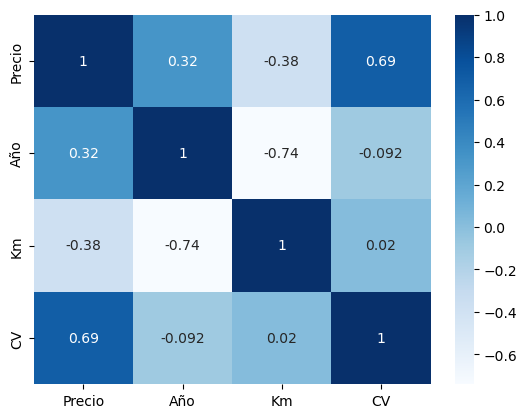

In [16]:
sns.heatmap(data = df.corr(), annot = True, cmap = "Blues")
plt.show()

In [17]:
df_cat = df.drop(df_num.columns, axis = 1)
df_cat.head(5)

,Combustible,Provincia,Marca
0,Diésel,Zaragoza,NISSAN
1,Gasolina,Valencia,MERCEDES-BENZ
2,Gasolina,Madrid,MITSUBISHI
3,Gasolina,Barcelona,PORSCHE
4,Gasolina,Ávila,MERCEDES-BENZ


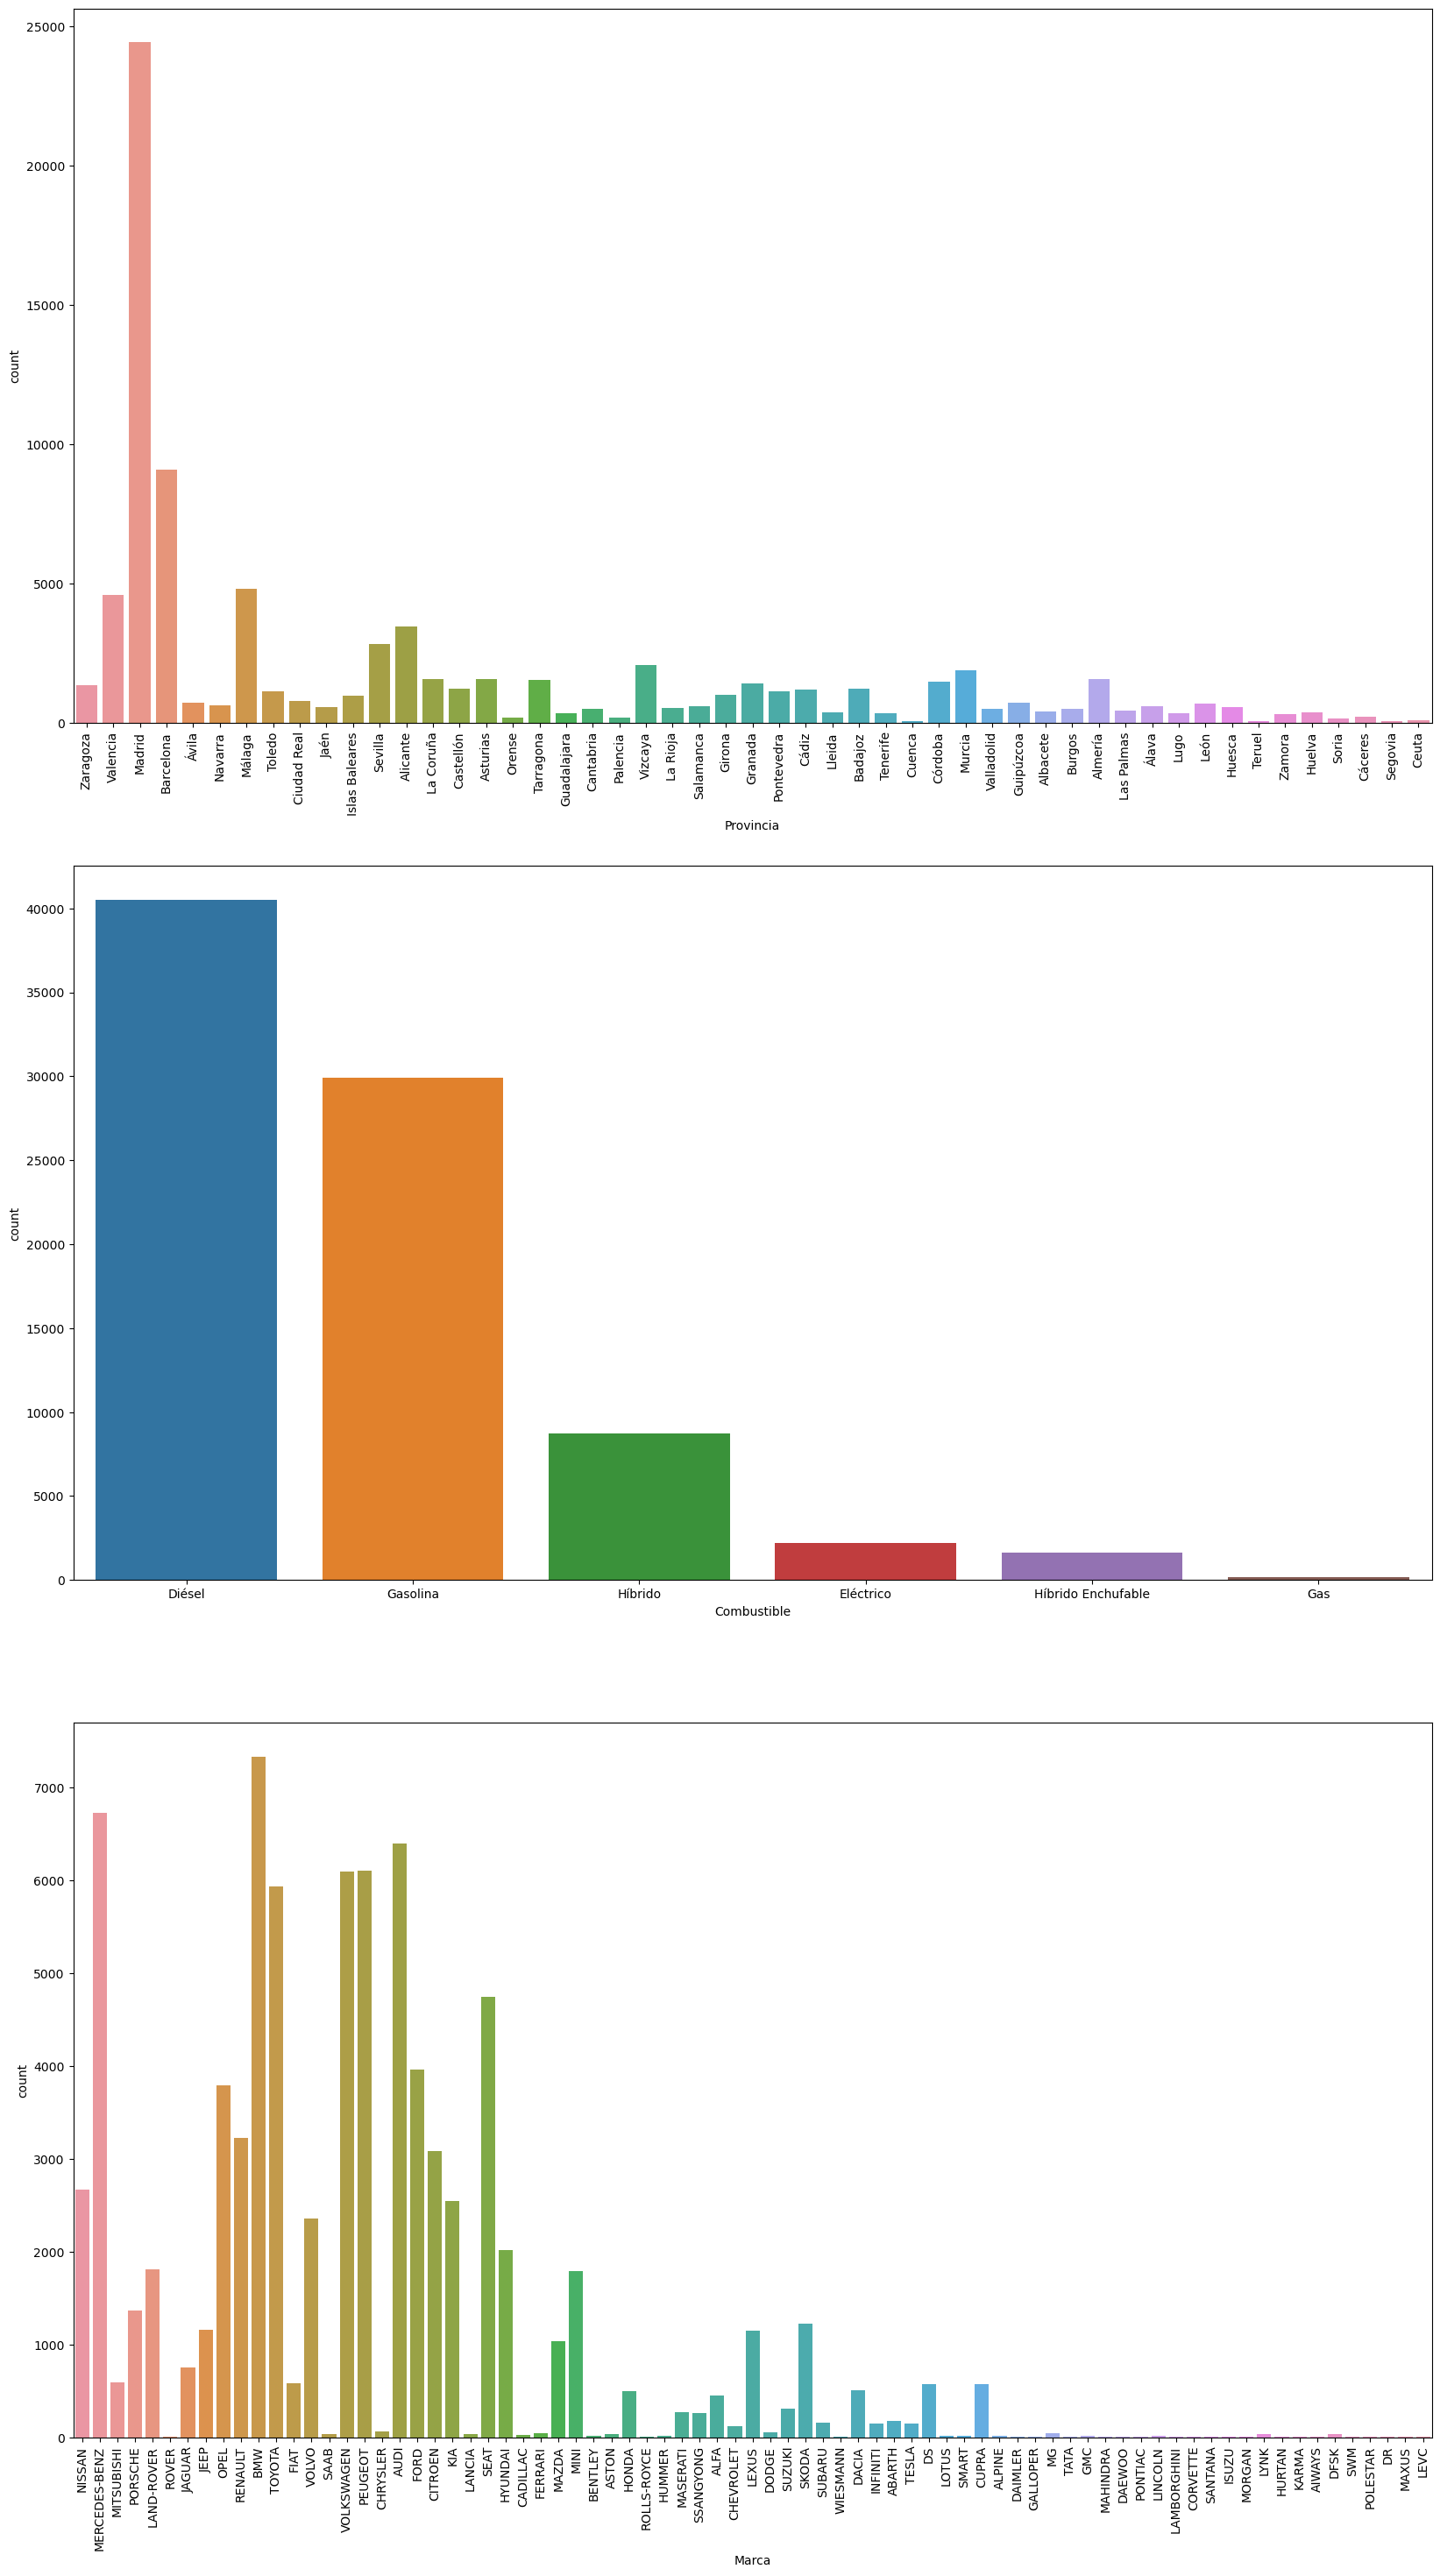

In [18]:
fig, ax = plt.subplots(3, 1, figsize = (20, 36))

sns.countplot(ax=ax[0], x=df_cat["Provincia"])
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 90)

sns.countplot(ax=ax[1], x = df_cat["Combustible"])
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 0)

sns.countplot(ax=ax[2], x = df_cat["Marca"])
ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation = 90)

plt.show()

Se crea una función para aplicar LabelEncoder a cada una de las variables categóricas.
Con la función además se generan las nuevas variables numéricas y se eliminan las categóricas iniciales

In [19]:
def ChangeCatNum(df_cat):
    encoders = {}
    for column in df_cat.columns:
        tempEncoder = LabelEncoder()
        tempColumn = tempEncoder.fit_transform(df_cat[column])
        df_cat[column] = tempColumn
        encoders[column] = tempEncoder
    return encoders

In [20]:
encoders = ChangeCatNum(df_cat)
encoders

{'Combustible': LabelEncoder(),
 'Provincia': LabelEncoder(),
 'Marca': LabelEncoder()}

In [21]:
df_cat

,Combustible,Provincia,Marca
0,0,48,53
1,3,44,48
2,3,29,51
3,3,5,58
4,3,50,48
...,...,...,...
83181,1,10,5
83182,3,50,69
83183,4,29,73
83184,3,46,23


Ahora obtenemos el DataFrame final uniendo df_cat y df_num

In [22]:
df_coches = pd.concat([df_cat, df_num], axis = 1)
df_coches.head()

,Combustible,Provincia,Marca,Precio,Año,Km,CV
0,0,48,53,7999,1993,293234,115.0
1,3,44,48,10990,1993,187000,320.0
2,3,29,51,5990,1993,80000,145.0
3,3,5,58,79000,1993,169000,250.0
4,3,50,48,4950,1993,250000,109.0


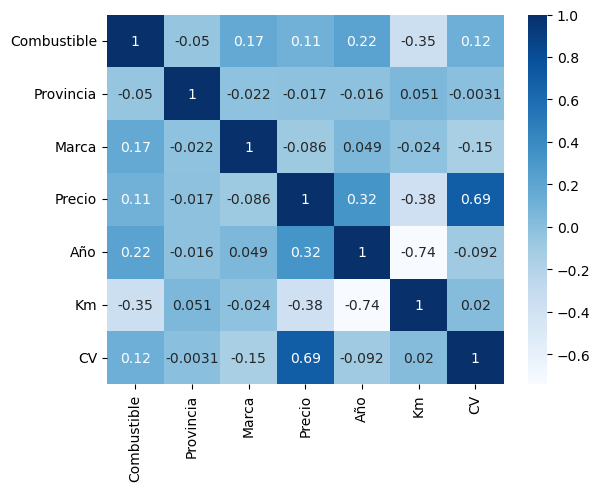

In [23]:
sns.heatmap(data = df_coches.corr(), annot = True, cmap = "Blues")
plt.show()

#
# Modelos y métricas 

Normalizamos los datos y generamos los conjuntos de entrenamiento y testeo

In [24]:
def DataTestTrain (df, ColumTest):
    X = np.array(df.drop(ColumTest, axis = 1))
    y = np.array(df[ColumTest])
    print(f"X.shape: {X.shape}, y.shape: {y.shape}")
    
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    X = x_scaler.fit_transform(X)
    y = y_scaler.fit_transform(y.reshape(-1, 1))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 30)

    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape},  y_test: {y_test.shape}")
    
    return X,X_train,X_test,y,y_train,y_test
    

In [25]:
X,X_train,X_test,y,y_train,y_test =  DataTestTrain(df_coches, "Precio")

X.shape: (83186, 6), y.shape: (83186,)
X_train: (66548, 6), y_train: (66548, 1)
X_test: (16638, 6),  y_test: (16638, 1)


## Modelos

Para realizar los ajustes de los datos se usaran los siguientes modelos:

    * Multiple Lineal Regression (MLR)
    * Nearest Neighbors Regression (KNR)
    * Support Vector Reggression (SVR)
    * Random Forest Reggression (RFR)

In [26]:
def models():
    
    # Inicializar los modelos de regresión
    model_MLR = LinearRegression()
    model_KNR = KNeighborsRegressor()
    model_SVR = SVR()
    model_RFR = RandomForestRegressor()
    
    # Entrenar los modelos
    model_MLR.fit(X_train, y_train)
    model_KNR.fit(X_train, y_train)
    model_SVR.fit(X_train, y_train)
    model_RFR.fit(X_train, y_train)
    
    # Realizar predicciones
    y_hat_MLR = model_MLR.predict(X_test)
    y_hat_KNR = model_KNR.predict(X_test)
    y_hat_SVR = model_SVR.predict(X_test)
    y_hat_RFR = model_RFR.predict(X_test)
    
    # y_test vs. y_hat
    fig, ax = plt.subplots(2, 2, figsize = (20, 15))
    fig.suptitle("Valores reales (y_test) vs. Valores predichos (y_hat)", size = 18)
    
    plt.subplot(2, 2, 1)
    sns.scatterplot(x = y_test.flatten(), y = y_hat_MLR.flatten(), alpha = 0.5, color = "blue").set_title('Multiple Lineal Regression (MLR)', size = 18)
    plt.xlabel("Valores Reales (y_test)", size = 14)
    plt.ylabel("Predicciones (y_hat)", size = 14)

    plt.subplot(2, 2, 2)
    sns.scatterplot(x = y_test.flatten(), y = y_hat_KNR.flatten(), alpha = 0.5, color = "blue").set_title('Nearest Neighbors Regression (KNR)', size = 18)
    plt.xlabel("Valores Reales (y_test)", size = 14)
    plt.ylabel("Predicciones (y_hat)", size = 14)
    
    plt.subplot(2, 2, 3)
    sns.scatterplot(x = y_test.flatten(), y = y_hat_SVR.flatten(), alpha = 0.5, color = "blue").set_title('Support Vector Regression (SVR)', size = 18)
    plt.xlabel("Valores Reales (y_test)", size = 14)
    plt.ylabel("Predicciones (y_hat)", size = 14)
    
    plt.subplot(2, 2, 4)
    sns.scatterplot(x = y_test.flatten(), y = y_hat_RFR.flatten(), alpha = 0.5, color = "blue").set_title('Random Forest Regression (RFR)', size = 18)
    plt.xlabel("Valores Reales (y_test)", size = 14)
    plt.ylabel("Predicciones (y_hat)", size = 14)

    plt.show()
    
    return (model_MLR, model_KNR, model_SVR, model_RFR, y_hat_MLR, y_hat_KNR, y_hat_SVR, y_hat_RFR )

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/folders/9s/wsnt_k11095cjkx4tjv97f3c0000gn/T/ipykernel_1277/3547699869.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_RFR.fit(X_train, y_train)


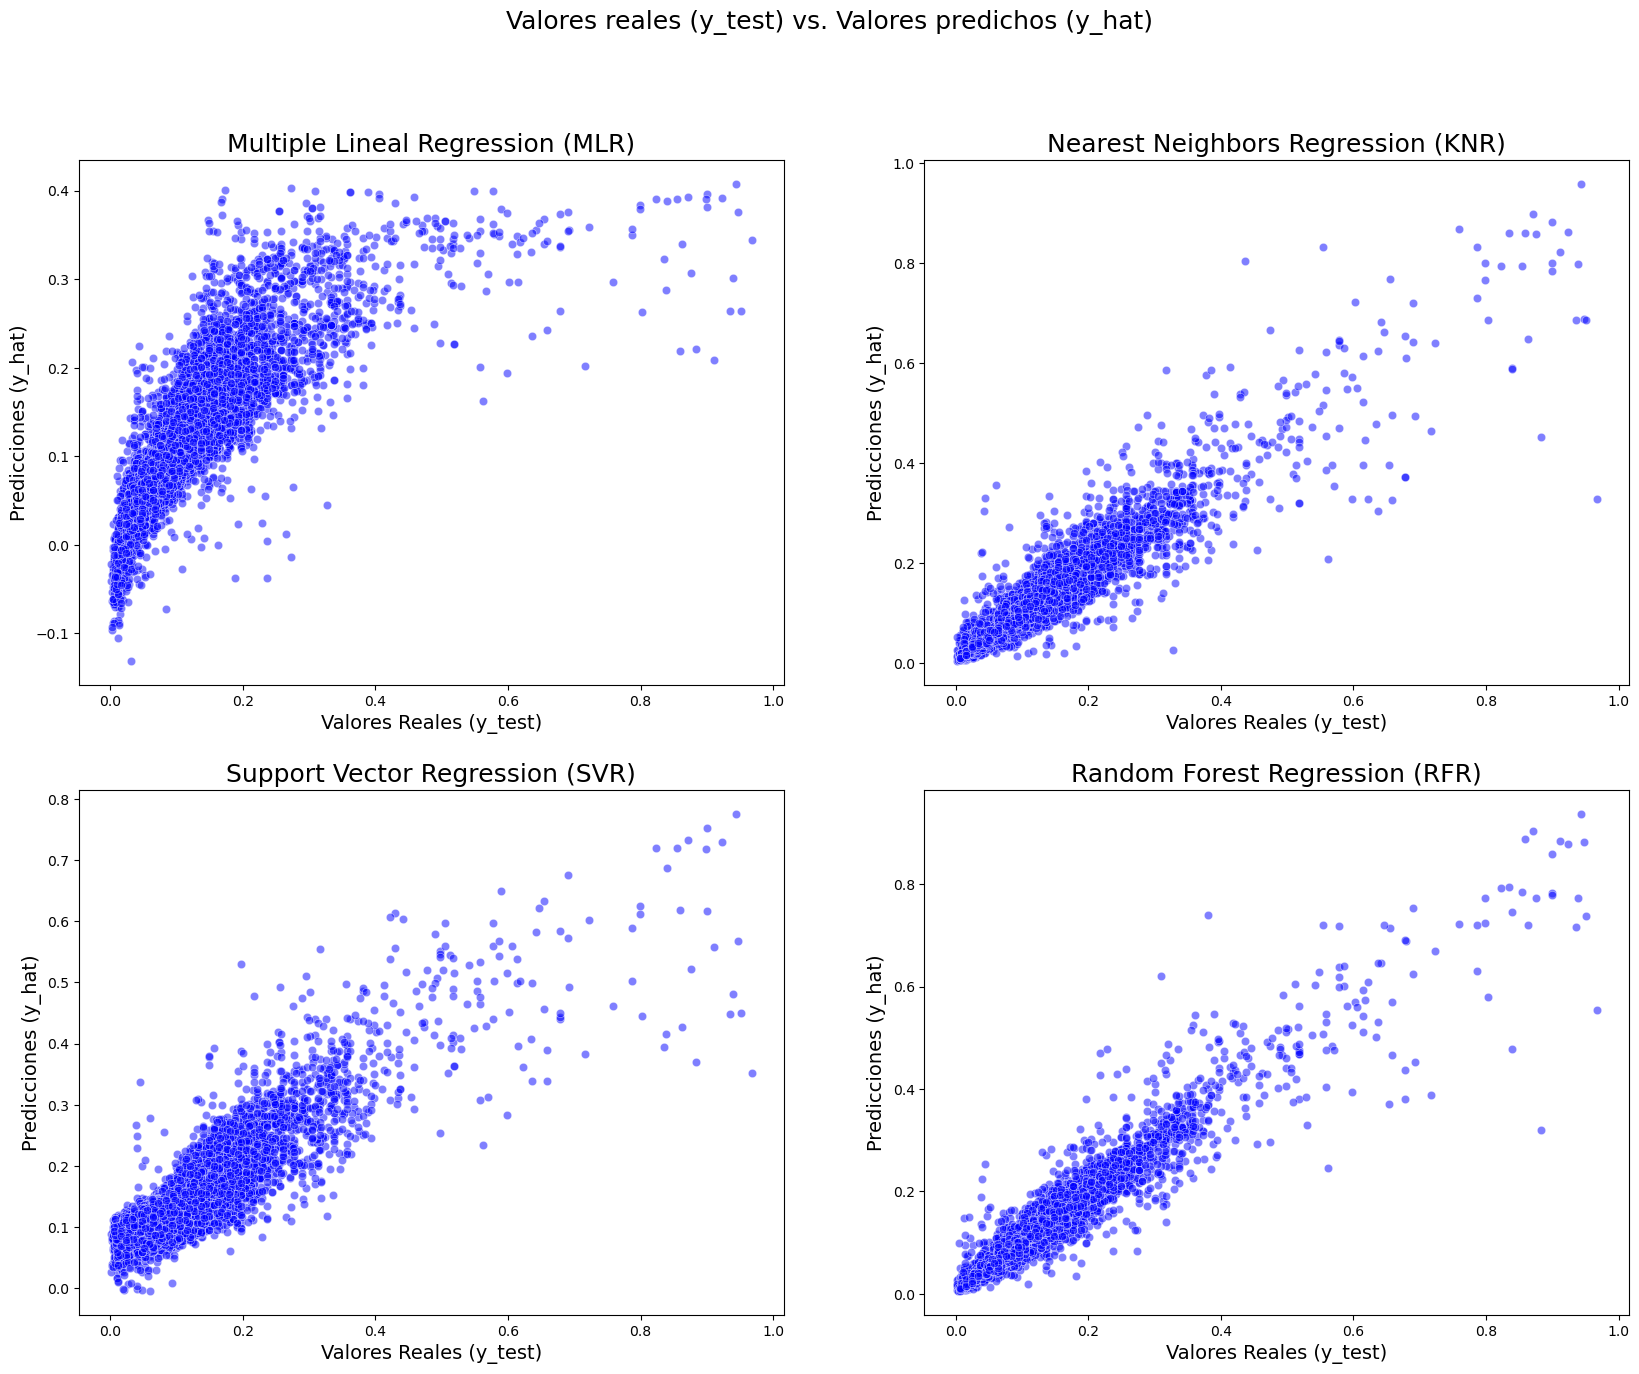

In [27]:
model_MLR, model_KNR, model_SVR, model_RFR, y_hat_MLR, y_hat_KNR, y_hat_SVR, y_hat_RFR  = models()

## Metricas

In [30]:
def metricas(model, y_hat_model):
    
    # Mean Absolute Error
    MAE = mean_absolute_error(y_test, y_hat_model)
    # Mean Squared Error
    MSE = mean_squared_error(y_test, y_hat_model)
    # R**2
    R2 = r2_score(y_test, y_hat_model)
    
    print(f"Metricas para el modelo {str(model)} ")
    print(f"MAE:\t {MAE}")
    print(f"MSE:\t {MSE}")
    print(f"R**2:\t {R2}")
    
    return (MAE, MSE, R2)
    

In [29]:
models = ["MLR", "KNR", "SVR", "RFR"]
metrics = []

for model in models:
    print("   ")
    metrics.append(metricas(globals()[f"model_{model}"], globals()[f"y_hat_{model}"]))
    print("   ")
    print("-----"*20)
    
results_metrics = [ { clave: [ valor ] } for clave, valor in zip(models, metrics) ]
    

   
Metricas para el modelo LinearRegression() 
MAE:	 0.022969291326348503
MSE:	 0.0017765155439088203
R**2:	 0.6746234441721859
   
----------------------------------------------------------------------------------------------------
   
Metricas para el modelo KNeighborsRegressor() 
MAE:	 0.013754038198713838
MSE:	 0.0006631213873763488
R**2:	 0.8785464310402047
   
----------------------------------------------------------------------------------------------------
   
Metricas para el modelo SVR() 
MAE:	 0.04383703365118747
MSE:	 0.0027378094488228885
R**2:	 0.49855828054800355
   
----------------------------------------------------------------------------------------------------
   
Metricas para el modelo RandomForestRegressor() 
MAE:	 0.010822251572782694
MSE:	 0.0004480058132932951
R**2:	 0.9179457849271186
   
----------------------------------------------------------------------------------------------------


In [31]:
results_metrics

[{'MLR': [(0.022969291326348503, 0.0017765155439088203, 0.6746234441721859)]},
 {'KNR': [(0.013754038198713838, 0.0006631213873763488, 0.8785464310402047)]},
 {'SVR': [(0.04383703365118747, 0.0027378094488228885, 0.49855828054800355)]},
 {'RFR': [(0.010822251572782694, 0.0004480058132932951, 0.9179457849271186)]}]

In [32]:
med = {}



In [33]:
#####  HACER ESTO PARA LA GRAFICA

dfvjc = {'modelos': ["MLR", "KNR", "SVR", "RFR"],
         'MAE': [round(0.022969291326348496,4), 
                 round(0.013754902625286577,4), 
                 round(0.04383703365118747,4), 
                 round(0.010825052742266916,4)],
         'MAE_colors' : {round(0.022969291326348496,4) : 'brown',
                         round(0.013754902625286577,4) : 'orange',
                         round(0.04383703365118747,4) : 'dodgerblue',
                         round(0.010825052742266916,4) : 'green'}, 
         'Rsquared' : [round(0.6746234441721858,4),
                       round(0.8785536520419795,4),
                       round(0.49855828054800344,4),
                       round(0.917296183068645,4)],
         'Rsquared_colors' : {round(0.6746234441721858,4) : 'brown',
                              round(0.8785536520419795,4) : 'orange',
                              round(0.49855828054800344,4) : 'dodgerblue',
                              round(0.917296183068645,4) : 'green'}, 
         'MSE' : [round(0.0017765155439088208,4),
                  round(0.0006630819616043752,4),
                  round(0.002737809448822889,4),
                  round(0.00045155255868186333,4)],
         'MSE_colors' : {round(0.0017765155439088208,4) : 'brown',
                         round(0.0006630819616043752,4) : 'orange',
                         round(0.002737809448822889,4) : 'dodgerblue',
                         round(0.00045155255868186333,4) : 'green'}}

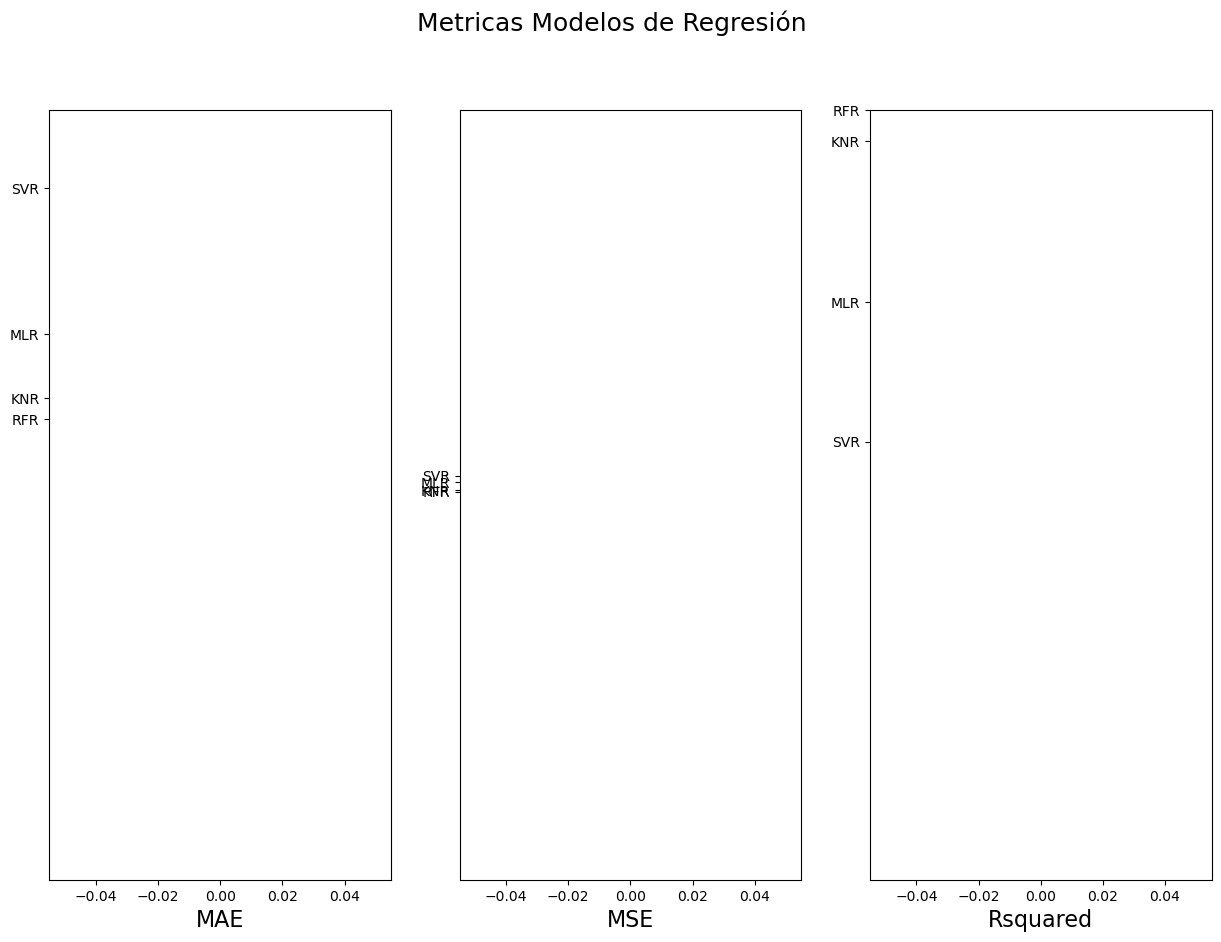

In [34]:
##### NO FUNCIONA


med = [[],[],[]]
for i in range(len(metrics)):
    for j in range(len(metrics[i])):
        med[j].append(metrics[i][j]) 
    
fig, ax = plt.subplots(1, 3, figsize = (15, 10))
fig.suptitle("Metricas Modelos de Regresión", size = 18)
    
plt.subplot(1, 3, 1)
sns.scatterplot(ax=ax[0], x = med[0], alpha = 0.5, color = "blue")
ax[0].set_yticks(med[0], labels=["MLR", "KNR", "SVR", "RFR"])
plt.xlabel("MAE", size = 16)

plt.subplot(1, 3, 2)
sns.scatterplot(ax=ax[1], x = med[1], alpha = 0.5, color = "blue")
ax[1].set_yticks(med[1], labels=["MLR", "KNR", "SVR", "RFR"])
plt.xlabel("MSE", size = 16)
  
plt.subplot(1, 3, 3)
sns.scatterplot(ax=ax[2], x = med[2], alpha = 0.5, color = "blue")
ax[2].set_yticks(med[2], labels=["MLR", "KNR", "SVR", "RFR"])
plt.xlabel("Rsquared", size = 16)
    
plt.show()

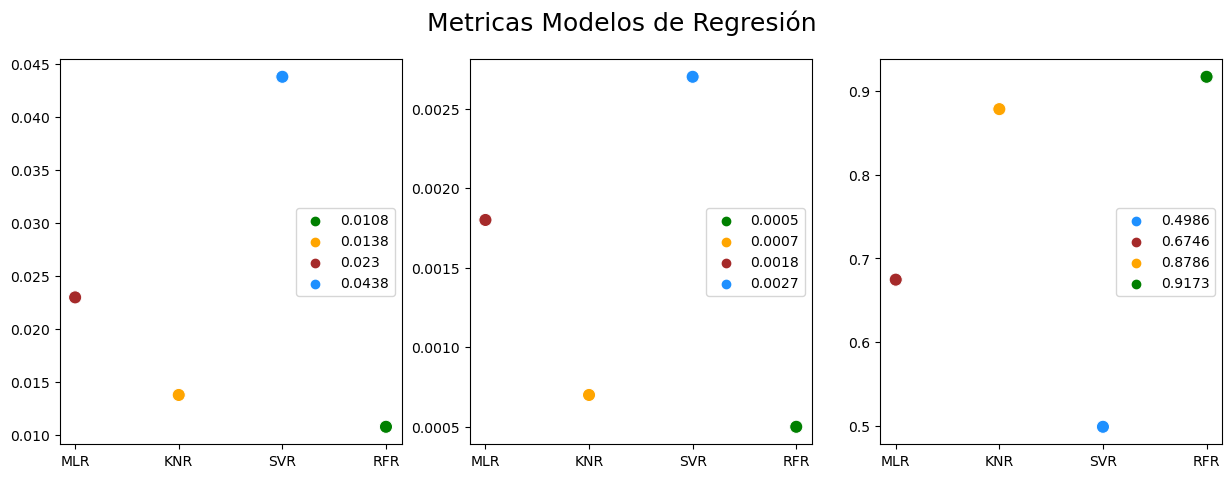

In [35]:
#### GRAFICA

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.suptitle("Metricas Modelos de Regresión", size = 18)

plt.subplot(1, 3, 1)
sns.scatterplot(data=dfvjc, x = 'modelos', y='MAE', s=90, hue='MAE',
                palette=dfvjc['MAE_colors'])
plt.xlabel("", size = 0)
plt.ylabel("", size = 0)
plt.legend(loc='center right')
plt.subplot(1, 3, 2)
sns.scatterplot(data=dfvjc, x = 'modelos', y='MSE',  s=90, hue='MSE',
                palette=dfvjc['MSE_colors'])
plt.xlabel("", size = 0)
plt.ylabel("", size = 0)
plt.legend(loc='center right')
plt.subplot(1, 3, 3)
sns.scatterplot(data=dfvjc, x = 'modelos', y='Rsquared',  s=90, hue='Rsquared',
                palette=dfvjc['Rsquared_colors'])
plt.xlabel("", size = 0)
plt.ylabel("", size = 0)
plt.legend(loc='center right')


## Métodos de Validación

### Hold-Out

In [ ]:
def HoldOut(model, num):
    list_r2 = list()
    for i in range(num):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
        model.fit(X_train, y_train)
        y_hat = model.predict(X_test)
        list_r2.append(r2_score(y_test, y_hat))
    print(f"Resultados para el modelo {str(model)} ")
    print(f"Min de R**2: {np.array(list_r2).min()}")
    print(f"Media de R**2: {np.array(list_r2).mean()}")
    print(f"Max de R**2: {np.array(list_r2).max()}")

In [37]:
HoldOut(model_MLR, 1000)

Resultados para el modelo LinearRegression() 
Min de R**2: 0.6458390248517272
Media de R**2: 0.6663792764157133
Max de R**2: 0.6900704228126495


In [38]:
HoldOut(model_KNR, 100)

Resultados para el modelo KNeighborsRegressor() 
Min de R**2: 0.8438605476438477
Media de R**2: 0.8618555824244984
Max de R**2: 0.87566932194


In [ ]:
HoldOut(model_SVR, 100)

In [ ]:
HoldOut(model_RFR, 10)

### Leave One Out

In [ ]:
def LeaveOneOut_fun(model):
    loo = LeaveOneOut()
    y_hat = list()
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_hat1 = model.predict(X_test)
        y_hat.extend(y_hat1)
    print(f"Resultados para el modelo {str(model)} ")
    print(f"R**2: {r2_score(y, y_hat)}")

In [ ]:
LeaveOneOut_fun(model_MLR) ## REQUIERE MUCHO TIEMPO PARA EJECUTARSE

In [ ]:
LeaveOneOut_fun(model_KNR) ## REQUIERE MUCHO TIEMPO PARA EJECUTARSE

In [ ]:
LeaveOneOut_fun(model_SVR) ## REQUIERE MUCHO TIEMPO PARA EJECUTARSE

In [ ]:
LeaveOneOut_fun(model_RFR) ## REQUIERE MUCHO TIEMPO PARA EJECUTARSE

### k-Fold Cross Validation

In [41]:
def KFold_fun(model, n):
    kfold = KFold(n_splits = n)
    y_hat = []
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_hat1 = model.predict(X_test)
        y_hat.extend(y_hat1)
    print(f"Resultados para el modelo {str(model)} ")
    print(f"R**2: {r2_score(y, y_hat)}")

In [42]:
KFold_fun(model_MLR, 5)

Resultados para el modelo LinearRegression() 
R**2: 0.6507920878914435


In [43]:
KFold_fun(model_KNR, 5)

Resultados para el modelo KNeighborsRegressor() 
R**2: 0.8565094603898277


In [44]:
KFold_fun(model_SVR, 5)

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

Resultados para el modelo SVR() 
R**2: 0.4783224278266228


In [45]:
KFold_fun(model_RFR, 5)

/var/folders/9s/wsnt_k11095cjkx4tjv97f3c0000gn/T/ipykernel_1277/3851970720.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
/var/folders/9s/wsnt_k11095cjkx4tjv97f3c0000gn/T/ipykernel_1277/3851970720.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
/var/folders/9s/wsnt_k11095cjkx4tjv97f3c0000gn/T/ipykernel_1277/3851970720.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
/var/folders/9s/wsnt_k11095cjkx4tjv97f3c0000gn/T/ipykernel_1277/3851970720.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

Resultados para el modelo RandomForestRegressor() 
R**2: 0.8939740669074423


## "Tuning" con GridSearchCV 

Después de evaluados los modelos y aplicados los métodos de validación, se determina que los modelos KNeighborsRegressor y RandomForestRegressor son los que presentan mejor desempeño.  Sin embargo para realizar el Tuning con GridSearchCV se usara el modelo Random Forest que presenta, aunque con muy poca diferencia, mejores resultados.

In [ ]:
params = {"n_estimators"           : [100, 200, 300], # Numero de arboles
          "criterion"              : ["squared_error", "absolute_error", "friedman_mse", "poisson"], # Es la función para medir la calidad de una división/split.
          "max_depth"              : [3, 4, 5, 6], # La profundidad máxima del árbol.
          "max_features"           : [2, 3, 4], # El número de características (atributos) a considerar en cada split
          "max_leaf_nodes"         : [8], # Maximo de nodos hoja del arbol
          "min_impurity_decrease"  : [0.02, 0.3], # Un nodo se dividirá si esta división induce una disminución de la impureza mayor o igual a este valor.
          "min_samples_split"      : [2, 5]} # El número mínimo de muestras requeridas para llegar a nodo hoja.

scorers = {"r2", "neg_mean_absolute_error", "neg_mean_squared_error"}

grid_solver = GridSearchCV(estimator  = model_RFR    , 
                           param_grid = params   , 
                           scoring    = scorers  ,
                           cv         = 5        ,
                           refit      = "r2",
                           n_jobs     = -1        )

model_result = grid_solver.fit(X_train, y_train)

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

In [ ]:
model_result.best_estimator_

In [ ]:
y_hat = model_result.best_estimator_.predict(X_test)

print(f"Metricas para el modelo {str(model)} ")
print(f"MAE:\t {mean_absolute_error(y_test, y_hat)}")
print(f"MSE:\t {mean_squared_error(y_test, y_hat)}")
print(f"R**2:\t {r2_score(y_test, y_hat)}")

In [ ]:
print(model_result.cv_results_["mean_test_recall_macro"].mean())
print(model_result.cv_results_["mean_test_f1_macro"].mean())
print(model_result.cv_results_["mean_test_accuracy"].mean())

print("*"*100)

print(model_result.best_score_)
print(model_result.best_params_)

In [ ]:
dfvjc = {'modelos': ["MLR", "KNR", "SVR", "RFR"],
                   'MAE': [round(0.022969291326348496,4), 
                           round(0.013754902625286577,4), 
                           round(0.04383703365118747,4), 
                           round(0.010825052742266916,4)],
        'MAE_colors' : {round(0.022969291326348496,4) : 'brown',
                       round(0.013754902625286577,4) : 'orange',
  round(0.04383703365118747,4) : 'dodgerblue',
  round(0.010825052742266916,4) : 'green'}, 
                    'Rsquared' : [round(0.6746234441721858,4),
  round(0.8785536520419795,4),
  round(0.49855828054800344,4),
  round(0.917296183068645,4)],
        'Rsquared_colors' : {round(0.6746234441721858,4) : 'brown',
                       round(0.8785536520419795,4) : 'orange',
  round(0.49855828054800344,4) : 'dodgerblue',
  round(0.917296183068645,4) : 'green'}, 
         'MSE' : [round(0.0017765155439088208,4),
  round(0.0006630819616043752,4),
  round(0.002737809448822889,4),
  round(0.00045155255868186333,4)],
        'MSE_colors' : {round(0.0017765155439088208,4) : 'brown',
                       round(0.0006630819616043752,4) : 'orange',
  round(0.002737809448822889,4) : 'dodgerblue',
  round(0.00045155255868186333,4) : 'green'}}

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.suptitle("Metricas Modelos de Regresión", size = 18)

plt.subplot(1, 3, 1)
sns.scatterplot(data=dfvjc, x = 'modelos', y='MAE', s=90, hue='MAE',
                palette=dfvjc['MAE_colors'])
plt.xlabel("", size = 0)
plt.ylabel("", size = 0)
plt.legend(loc='center right')
plt.subplot(1, 3, 2)
sns.scatterplot(data=dfvjc, x = 'modelos', y='MSE',  s=90, hue='MSE',
                palette=dfvjc['MSE_colors'])
plt.xlabel("", size = 0)
plt.ylabel("", size = 0)
plt.legend(loc='center right')
plt.subplot(1, 3, 3)
sns.scatterplot(data=dfvjc, x = 'modelos', y='Rsquared',  s=90, hue='Rsquared',
                palette=dfvjc['Rsquared_colors'])
plt.xlabel("", size = 0)
plt.ylabel("", size = 0)
plt.legend(loc='center right')
